In [ ]:
pip install emoji pyLDAvis pycld2 polyglot pyicu Morfessor

In [298]:
import pandas as pd 
import nltk,spacy,re,emoji,pyLDAvis,requests,gensim,pyLDAvis
from  nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from gensim import models,corpora
from polyglot.text import Text, Word
from polyglot.downloader import downloader
import pyLDAvis.gensim
from time import time
downloader.download("embeddings2.en")
downloader.download("ner2.en")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
sns.set_style('darkgrid')
try: df = pd.read_csv('/content/drive/My Drive/Tweets-A.csv')
except : df = pd.read_csv('Tweets-A.csv')
df.head()

[polyglot_data] Downloading package embeddings2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package embeddings2.en is already up-to-date!
[polyglot_data] Downloading package ner2.en to /root/polyglot_data...
[polyglot_data]   Package ner2.en is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,cairdin,@VirginAmerica What @dhepburn said.,NaN,24/02/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,jnardino,@VirginAmerica plus you've added commercials t...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/15 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,24/02/15 11:14,NaN,Pacific Time (US & Canada)


In [299]:
#function for treatment of verbs form and apostrophe in text
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 612, height = 612, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='black')
    print()
    plt.imshow(word_cloud),plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

def common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data: total_counts+=t.toarray()[0]
    count_dict = sorted((zip(words, total_counts)), key=lambda x:x[1], reverse=True)[:50]
    words,counts = [w[0] for w in count_dict],[w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(None, figsize = (15, 10))
    plt.subplot(title = '50 Most Common Words After cleaning entities')
    sns.set_context("notebook", font_scale = 0.8, rc={"lines.linewidth": 1})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

def save_dataframe():
  try: df_data.to_csv('/content/drive/My Drive/'+str(int(time()))+'_Update_TS.csv')
  except: df_data.to_csv(str(int(time()))+'_Update_TS.csv')

In [300]:
#TweetId is primary key.......Tweet_cord has more than 80% of missing rows so dropped it
df_data = df.copy()
df_data.drop(columns=['tweet_id','tweet_coord'],inplace=True)

#Column ['Text'] pre-processing by converting it to lower case
df_data.text = df_data.text.apply(lambda text:text.lower() if type(text) == str else text)

#HREF Links Removal
df_data.text = df_data.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))
# df_data.text = df_data.text.apply(lambda text: re.compile(r'http?://\S+|www\.\S+').sub(r'',text))
#HTML Text Removal
df_data.text = df_data.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

#HashTags Separation And Merging
df_data['hashtags'] = [ [ tag[1: ] for tag in i.split() if tag.startswith('#') ] for i in df_data.text ]

#@Entities Separation And Merging
df_data['tags'] = [ [ ent[1: ] for ent in i.split() if ent.startswith("@") ] for i in df_data.text ]

#Decontraction
df_data.text = df_data.text.apply(lambda x :decontracted(x))

# @Words Removal from text
df_data.text = [ " ".join([ sent for sent in text.split(" ") if sent.startswith("@") == False  ]) for text in df_data.text]

#converting emojis to words.
df_data.text = df_data.text.apply(lambda text : re.sub('_',' ',emoji.demojize(text)))

#Punctuations Removal
df_data.text = df_data.text.str.replace('[^\w\s]','')

#StopWords Removal
df_data.text = [ " ".join(([word for word in word_tokenize(i) if not word in list((stopwords.words('english')))]))  for i in df_data.text ]

#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
df_data.text = df_data.text.apply(lambda text: lemmatizer.lemmatize(text))

#Tokenization - We'll be using white space tokenizer as other tokenizers separate on condition which doesn't help us portray meaninng of words
df_data['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df_data.text]

#MissingValues in Columns ['user_timezone','tweet_location']
df_data.tweet_location,df_data.user_timezone = [df_data[i].fillna(df_data[i].value_counts().nlargest(n=1).index[0]) for i in ['tweet_location','user_timezone']]

#Recheck for missing values
print("No Missing Data" if (all(df_data.isna().any()==False )) else False)
df_data.head(10)

# Converting Tweet Created Column from dd/mm/yy h:m:s to dd:mm:yyyy
df_data.tweet_created = df.tweet_created.apply(lambda string : "/".join(string.split()[0].split("/")[:2])+"/20"+string.split()[0].split("/")[2] )

No Missing Data


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 0, 'entities mentioned')

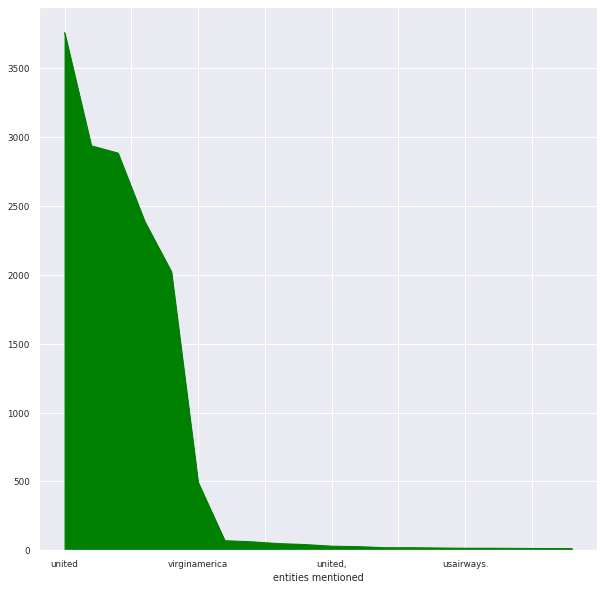

In [301]:
# Converting Array Tags into string and visualising them
split_data = df_data.copy()
split_data,split_data.tags = df_data.iloc[[i for i,j in enumerate(df_data['tags']) for value in j] , :],[value for i in df_data['tags'] for value in i]
split_data.tags.value_counts()[:20].plot.area(figsize=[10,10],color="g").set_xlabel('entities mentioned')
#Maximum tweets mentioned {united airways},then {virginamerica}

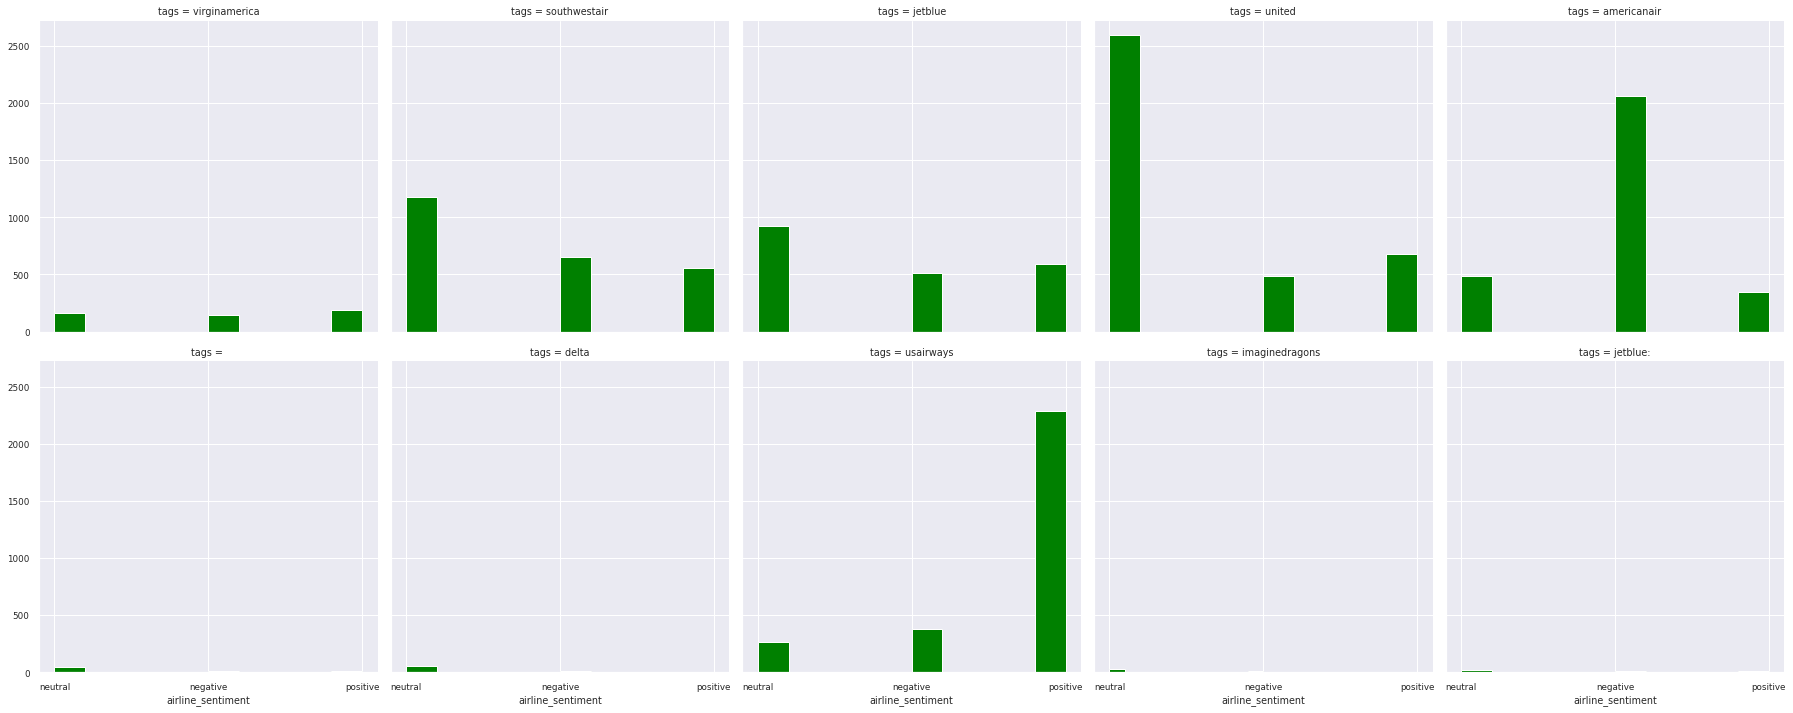

In [302]:
raw_df = split_data[(split_data.tags.isin(split_data.tags.value_counts()[:10].index.to_list()))]
a = sns.FacetGrid(raw_df,col="tags",col_wrap=5, height=5,aspect =1)
a = a.map(plt.hist,'airline_sentiment',color='g')
# virgin america airways have almost equal number of positive negative and neutral
# southwestair have neutral higher means it is ok for airline to continue
# most negative are of american air which shd be a pressing issue
# positive sentiment is maximum for usairways 

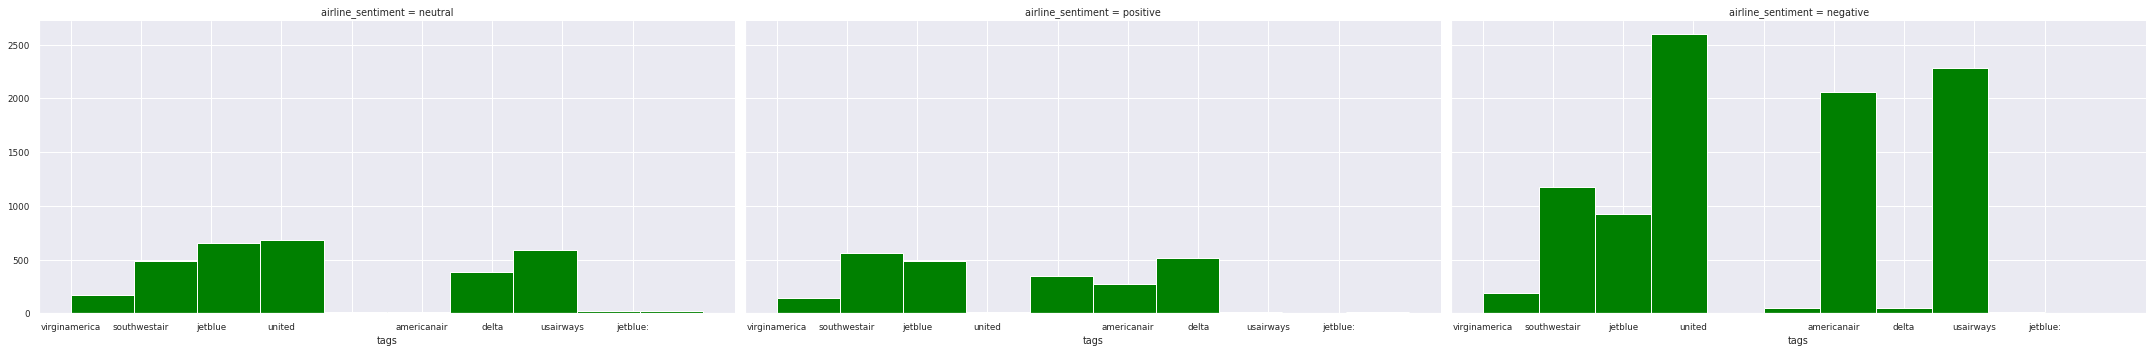

In [303]:
a = sns.FacetGrid(raw_df,col="airline_sentiment",col_wrap=3, height=5,aspect =2)
a = a.map(plt.hist,'tags',color='g')

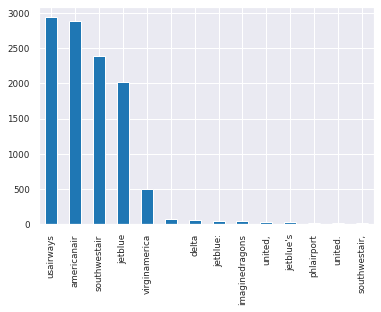

In [304]:
split_data.tags.value_counts()[1:15].plot.bar()

Text(0.5, 0, '')

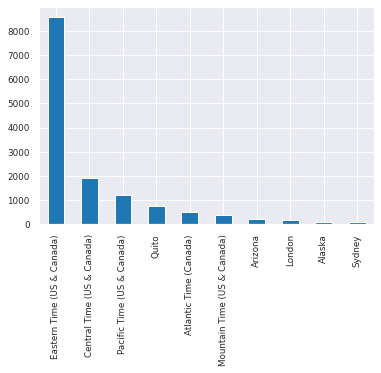

In [305]:
#Top 10 Timezones
df_data['user_timezone'].value_counts().sort_values(ascending=False)[:10].plot.bar().set_xlabel('')

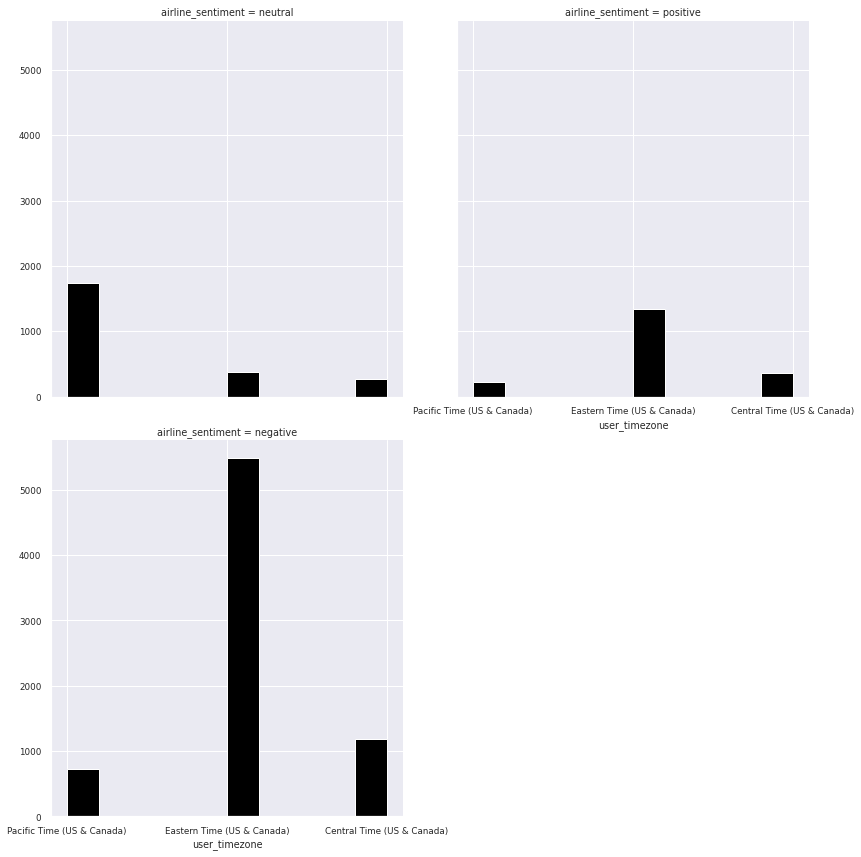

In [306]:
# Top 3 timezones with tweets in comparision to sentiment
a=sns.FacetGrid(df_data[df_data['user_timezone'].isin(df_data.user_timezone.value_counts()[:3].index.to_list())],col='airline_sentiment',col_wrap=2,height=6,)
a=a.map(plt.hist,'user_timezone',color='0')

Text(0.5, 0, 'Sentiments_Division')

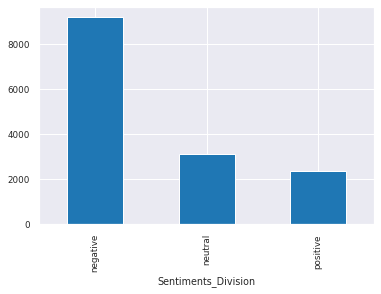

In [307]:
df_data['airline_sentiment'].value_counts().plot.bar().set_xlabel('Sentiments_Division')
# Out of 14500 Tweets it is visible that more than 70% of tweets have negative sentiment
# It can also be a problem which can be more clearly told after topic or entities are separated from text with respect to sentiment

In [ ]:
dictionary_LDA = gensim.corpora.Dictionary(df_data.tokenised_text)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in df_data.tokenised_text]
%time lda_model = models.LdaModel(corpus, num_topics=50,id2word=dictionary_LDA,passes=4,alpha=[0.01]*num_topics,eta=[0.01]*len(dictionary_LDA.keys()))

In [309]:
# CommonTopics With Thier Occurent With Chars
for i,topic in lda_model.show_topics(formatted=True, num_topics=10):
    print(topic)
lda_model[corpus[1]]

0.111*"flight" + 0.075*"awesome" + 0.057*"planes" + 0.049*"catering" + 0.046*"monday" + 0.042*"tuesday" + 0.041*"changed" + 0.035*"philly" + 0.035*"load" + 0.032*"sfo"
0.117*"see" + 0.108*"right" + 0.089*"website" + 0.071*"understand" + 0.041*"site" + 0.038*"high" + 0.034*"went" + 0.034*"else" + 0.028*"hopefully" + 0.027*"broken"
0.131*"two" + 0.080*"already" + 0.080*"well" + 0.078*"dm" + 0.074*"sent" + 0.072*"w" + 0.053*"leave" + 0.036*"sucks" + 0.033*"stay" + 0.031*"wifi"
0.148*"home" + 0.108*"stuck" + 0.055*"phl" + 0.049*"clt" + 0.048*"stop" + 0.044*"get" + 0.042*"us" + 0.035*"might" + 0.030*"runway" + 0.026*"lot"
0.135*"crew" + 0.081*"dallas" + 0.063*"supposed" + 0.062*"come" + 0.044*"car" + 0.043*"maybe" + 0.037*"apology" + 0.034*"plane" + 0.030*"moved" + 0.030*"landed"
0.097*"left" + 0.080*"yesterday" + 0.070*"many" + 0.059*"hi" + 0.057*"year" + 0.047*"message" + 0.043*"get" + 0.041*"saying" + 0.037*"together" + 0.030*"platinum"
0.304*"help" + 0.153*"need" + 0.143*"please" + 0.05

[(10, 0.22444445), (24, 0.22444446), (27, 0.22444445), (29, 0.22444445)]

In [310]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

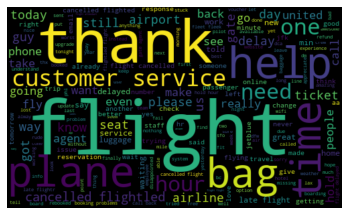

In [311]:
# WordCloudVisualisation
allWords = ' '.join([twts for twts in df_data.text])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear"),plt.axis('off')
plt.show()

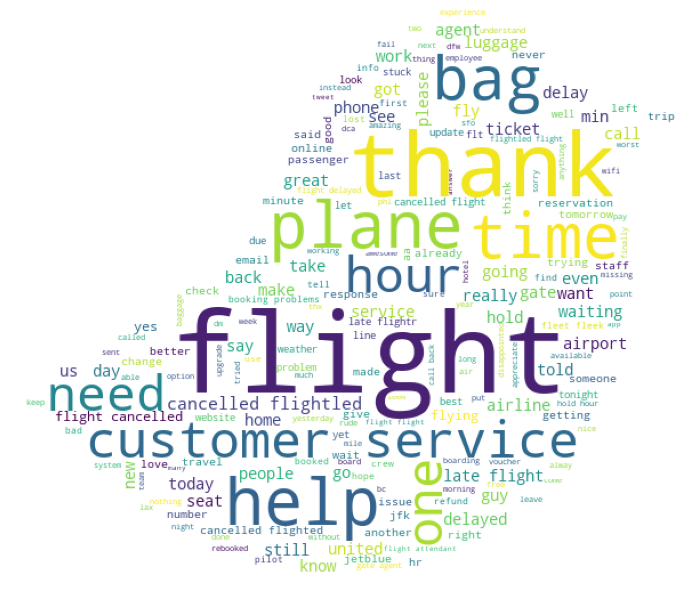

In [312]:
# Most Frequent Words In Whole Text
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/F/O/V/V/E/w/tweeter-bird-hi.png', stream=True).raw))
generate_wordcloud(' '.join([twts for twts in df_data.text]), mask)

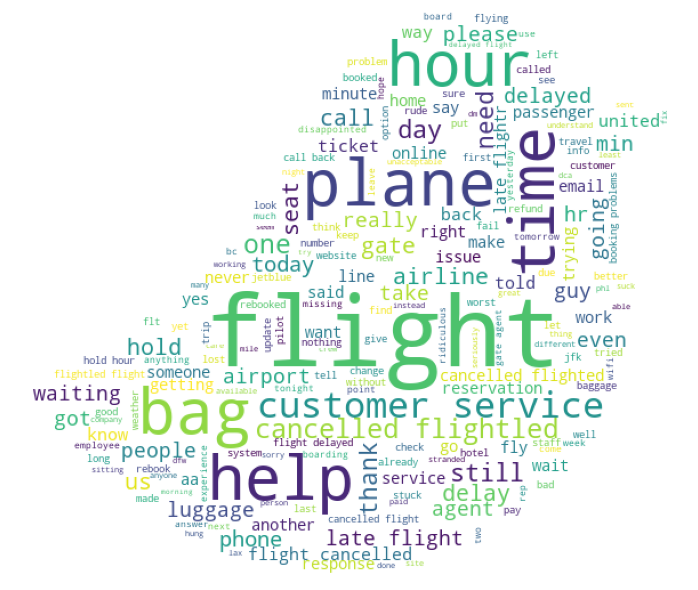

In [313]:
# Most Frequent Words In Negative Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "negative", 'text']]), mask)

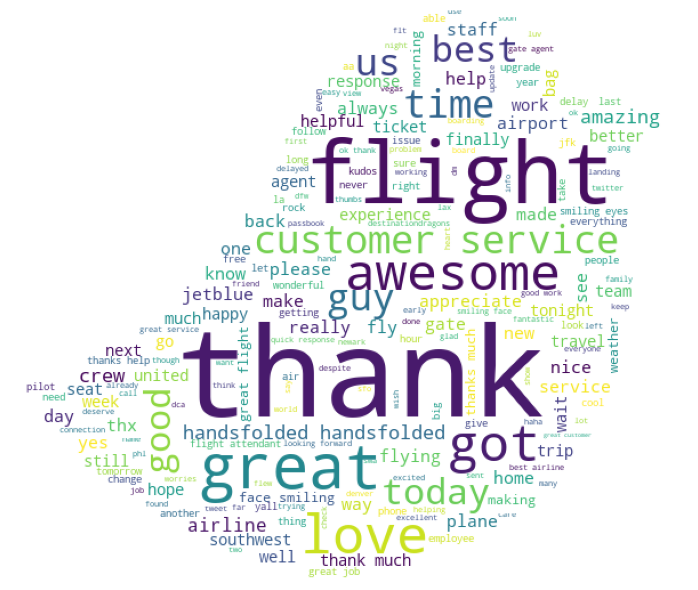

In [314]:
# Most Frequent Word In Positive Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "positive", 'text']]), mask)

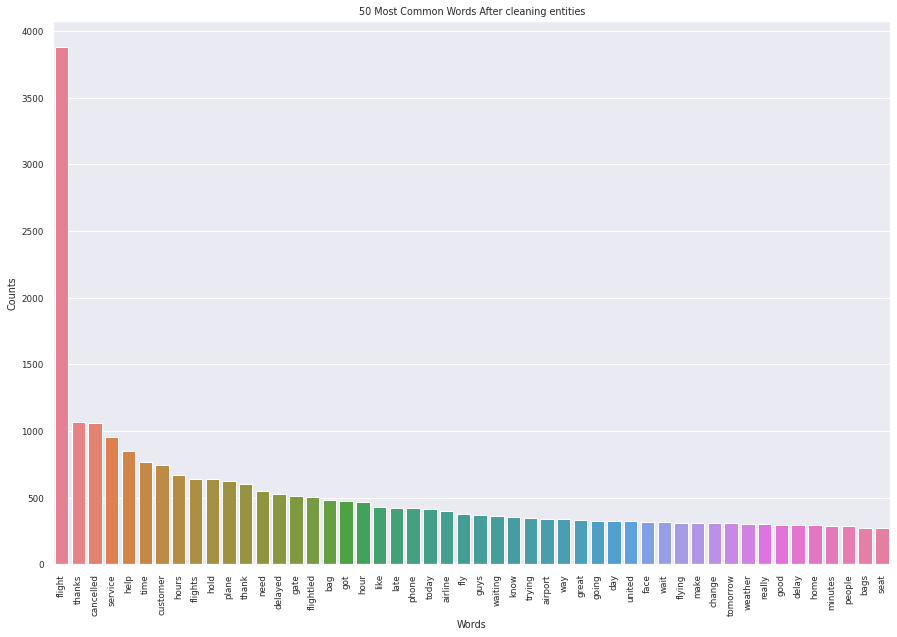

In [315]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_data['text'])

# Visualise the 50 most common words after cleaning entities and text
common_words(count_data, count_vectorizer)

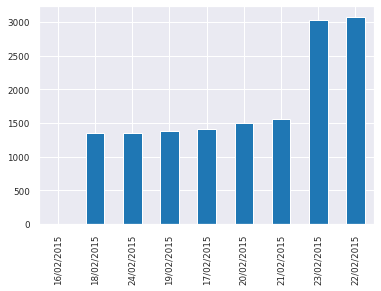

In [316]:
# Tweet Created Frequency v/s Time Distribution
df_data.tweet_created.value_counts().sort_values(ascending=True).plot.bar()

In [317]:
df_data['tweet_created']= pd.to_datetime(df['tweet_created'])
df_data['tweet_time'] = df_data.tweet_created.apply(lambda d : "day" if datetime.datetime.time(d).hour >=6 and datetime.datetime.time(d).hour<18 else "evening or night" )

Text(0.5, 0, 'timing of tweet')

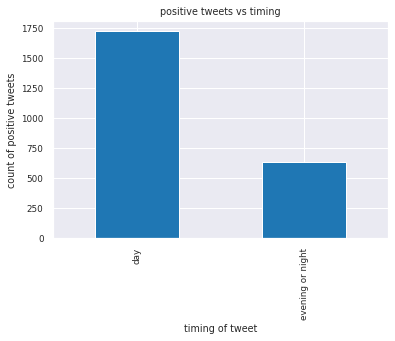

In [318]:
# positive tweets vs timing
f = df_data.tweet_time[df_data['airline_sentiment'] == 'positive'].value_counts().plot.bar()
f.set_title('positive tweets vs timing')
f.set_ylabel('count of positive tweets')
f.set_xlabel('timing of tweet')

Text(0.5, 0, 'timing of tweet')

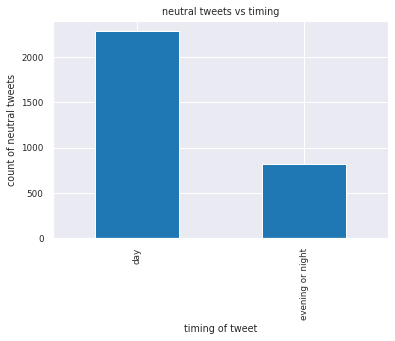

In [319]:
# neutral tweets vs timing
f1 = df_data.tweet_time[df_data['airline_sentiment'] == 'neutral'].value_counts().plot.bar()
f1.set_title('neutral tweets vs timing')
f1.set_ylabel('count of neutral tweets')
f1.set_xlabel('timing of tweet')

Text(0.5, 0, 'timing of tweet')

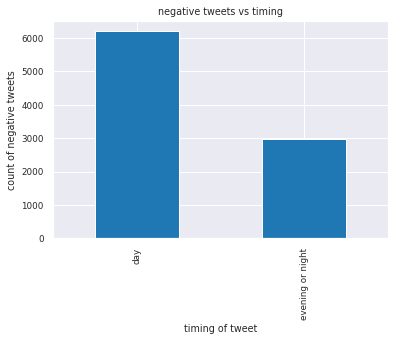

In [320]:
# negative tweets vs timing
f2 = df_data.tweet_time[df_data['airline_sentiment'] == 'negative'].value_counts().plot.bar()
f2.set_title('negative tweets vs timing')
f2.set_ylabel('count of negative tweets')
f2.set_xlabel('timing of tweet')

In [321]:
entities = [ i['node']['name'] for i in requests.get('https://cache-api.ranker.com/lists/386932/items?limit=200&offset=0').json()['listItems']]
tags = list(dict.fromkeys([ j for i in df_data.tags for j in i]))

In [322]:
positiveTokens = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'positive']['text']]))
negativeTokens = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'negative']['text']]))
neutralTokens  = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'neutral']['text']]))
print("Positive Token - {}\nNegative Tokens - {}\nNeutral Tokens - {}".format(len(positiveTokens),len(negativeTokens),len(neutralTokens)))

Positive Token - 17837
Negative Tokens - 92343
Neutral Tokens - 22589


PolyGlot Approach For Entity Recogniton

In [323]:
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in df_data[df_data['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))

Total 14620
Failed 11298
Success but can be inaccurate 3322


In [329]:
df_data[df_data['text'].str.len()>1]


,airline_sentiment,name,text,tweet_created,tweet_location,user_timezone,hashtags,tags,tokenised_text,tweet_time
0,neutral,cairdin,said,2015-02-24 11:35:00,"Boston, MA",Eastern Time (US & Canada),[],"[virginamerica, dhepburn]",[said],day
1,positive,jnardino,plus added commercials experience tacky,2015-02-24 11:15:00,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[plus, added, commercials, experience, tacky]",day
2,neutral,yvonnalynn,today must mean need take another trip,2015-02-24 11:15:00,Lets Play,Central Time (US & Canada),[],[virginamerica],"[today, must, mean, need, take, another, trip]",day
3,negative,jnardino,really aggressive blast obnoxious entertainmen...,2015-02-24 11:15:00,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[really, aggressive, blast, obnoxious, enterta...",day
4,negative,jnardino,really big bad thing,2015-02-24 11:14:00,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[really, big, bad, thing]",day
...,...,...,...,...,...,...,...,...,...,...
14635,positive,KristenReenders,thank got different flight chicago,2015-02-22 12:01:00,"Boston, MA",Eastern Time (US & Canada),[],[americanair],"[thank, got, different, flight, chicago]",day
14636,negative,itsropes,leaving 20 minutes late flight warnings commun...,2015-02-22 11:59:00,Texas,Eastern Time (US & Canada),[],[americanair],"[leaving, 20, minutes, late, flight, warnings,...",day
14637,neutral,sanyabun,please bring american airlines blackberry10,2015-02-22 11:59:00,"Nigeria,lagos",Eastern Time (US & Canada),[blackberry10],[americanair],"[please, bring, american, airlines, blackberry10]",day
14638,negative,SraJackson,money change flight answer phones suggestions ...,2015-02-22 11:59:00,New Jersey,Eastern Time (US & Canada),[],[americanair],"[money, change, flight, answer, phones, sugges...",day


In [324]:
##############On-Going Work####################
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Mozilla/5.0 (Macintosh; U; PPC Mac OS X; fi-fi) AppleWebKit/420+ (KHTML, like Gecko) Safari/419.3")
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
df_data['coordinate'] = df_data['tweet_location'].apply(geocode)
df_data['latitude'] = df_data.coordinate.apply(lambda x : x.latitude if x!= None else None)
df_data['longitude'] = df_data.coordinate.apply(lambda x : x.longitude if x!= None else None)